Import all the libraries


overview:
1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2023-05-18 10:18:26.516217: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-18 10:18:26.603659: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-18 10:18:26.832278: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-18 10:18:26.833405: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-18 10:18:28.310443: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

## Examine and understand data

In [3]:
import pathlib #helps to work with the file paths
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True) #download the image and saving it in our LD
data_dir = pathlib.Path(data_dir)
print(data_dir)

/home/hemanth/.keras/datasets/flower_photos


Counting the number of images

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg'))) #retrive the file path and search for the .jpg file 
print(image_count)

1973


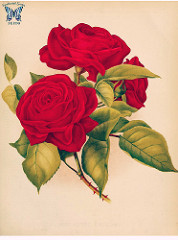

In [5]:
roses = (list(data_dir.glob('roses/*')))
PIL.Image.open(str(roses[0]))

Selecting the first image from the rose group

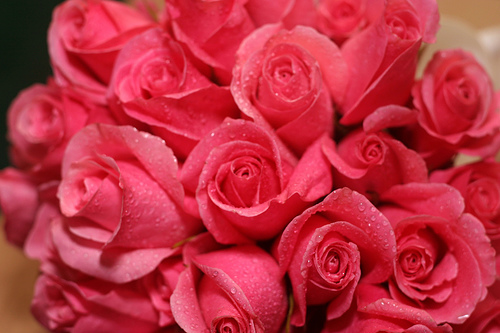

In [6]:
PIL.Image.open(str(roses[1]))

Loading the data using the keras utility

## Build pipeline

How image would be loaded:


In [7]:
batch_size = 16
img_height = 180
img_width = 180

sperating the dataset into training(80%) and validation group(20%)

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1973 files belonging to 3 classes.
Using 1579 files for training.


In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1973 files belonging to 3 classes.
Using 394 files for validation.


Find which dir are present

In [10]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'roses', 'sunflowers']


## Visualize the data
Some of the samples from the training dataset


2023-05-18 10:18:31.254674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1579]
	 [[{{node Placeholder/_4}}]]
2023-05-18 10:18:31.255367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1579]
	 [[{{node Placeholder/_0}}]]


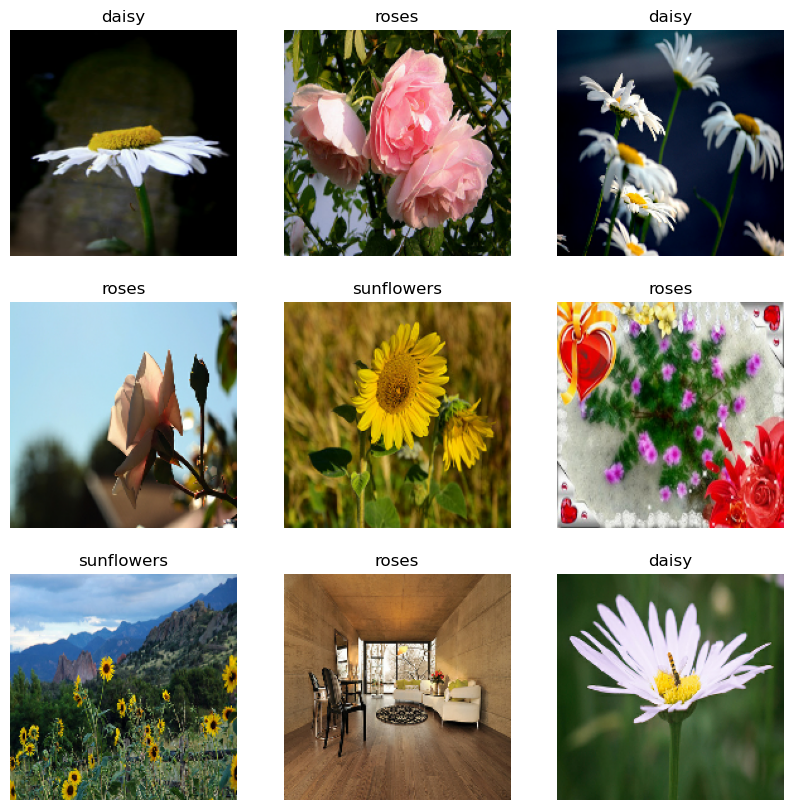

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 180, 180, 3)
(16,)


2023-05-18 10:18:32.467616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1579]
	 [[{{node Placeholder/_4}}]]
2023-05-18 10:18:32.475303: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1579]
	 [[{{node Placeholder/_4}}]]


## Configure the dataset for performance
- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## standarize the data
- 'RGB' contains values ranging from 0 to 255 which is not for neural network
- so use 'tf.keras.layers.scaling' to make into 0 to 1 range

In [14]:
normalization_layer = layers.Rescaling(1./255)

from the dataset 

In [15]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

2023-05-18 10:18:32.645097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1579]
	 [[{{node Placeholder/_4}}]]
2023-05-18 10:18:32.645922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1579]
	 [[{{node Placeholder/_4}}]]


0.0 0.9998475


## A basic Keras model


In [16]:

num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model


adam optimiser is used to upadate the weights

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model summary

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

## Train model

In [19]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


2023-05-18 10:18:45.464626: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1579]
	 [[{{node Placeholder/_4}}]]
2023-05-18 10:18:45.465296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1579]
	 [[{{node Placeholder/_4}}]]


99/99 [==============================] - ETA: 0s - loss: 0.8532 - accuracy: 0.6390

2023-05-18 10:18:55.535006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [394]
	 [[{{node Placeholder/_0}}]]
2023-05-18 10:18:55.535547: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [394]
	 [[{{node Placeholder/_0}}]]


99/99 [==============================] - 11s 100ms/step - loss: 0.8532 - accuracy: 0.6390 - val_loss: 0.7181 - val_accuracy: 0.7208
Epoch 2/10
99/99 [==============================] - 10s 98ms/step - loss: 0.5820 - accuracy: 0.7543 - val_loss: 0.6008 - val_accuracy: 0.7766
Epoch 3/10
99/99 [==============================] - 10s 99ms/step - loss: 0.4449 - accuracy: 0.8328 - val_loss: 0.5568 - val_accuracy: 0.7919
Epoch 4/10
99/99 [==============================] - 10s 99ms/step - loss: 0.3747 - accuracy: 0.8474 - val_loss: 0.6044 - val_accuracy: 0.7563
Epoch 5/10
99/99 [==============================] - 10s 99ms/step - loss: 0.2477 - accuracy: 0.9037 - val_loss: 0.7848 - val_accuracy: 0.7183
Epoch 6/10
99/99 [==============================] - 10s 98ms/step - loss: 0.1633 - accuracy: 0.9481 - val_loss: 0.6040 - val_accuracy: 0.7919
Epoch 7/10
99/99 [==============================] - 11s 107ms/step - loss: 0.0718 - accuracy: 0.9785 - val_loss: 0.7967 - val_accuracy: 0.7843
Epoch 8/10
99/9

## Visualize training results

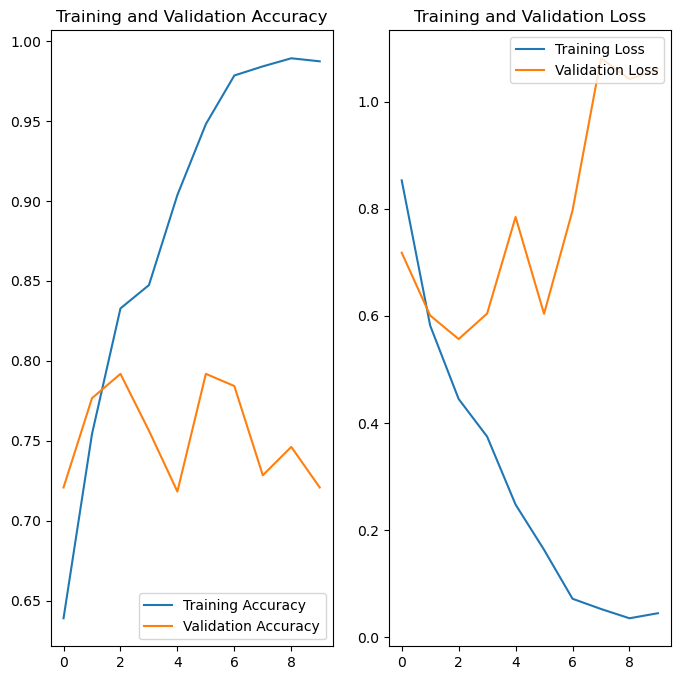

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Data augmentation

In [25]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

2023-05-18 10:22:29.251576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1579]
	 [[{{node Placeholder/_0}}]]
2023-05-18 10:22:29.252692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1579]
	 [[{{node Placeholder/_4}}]]


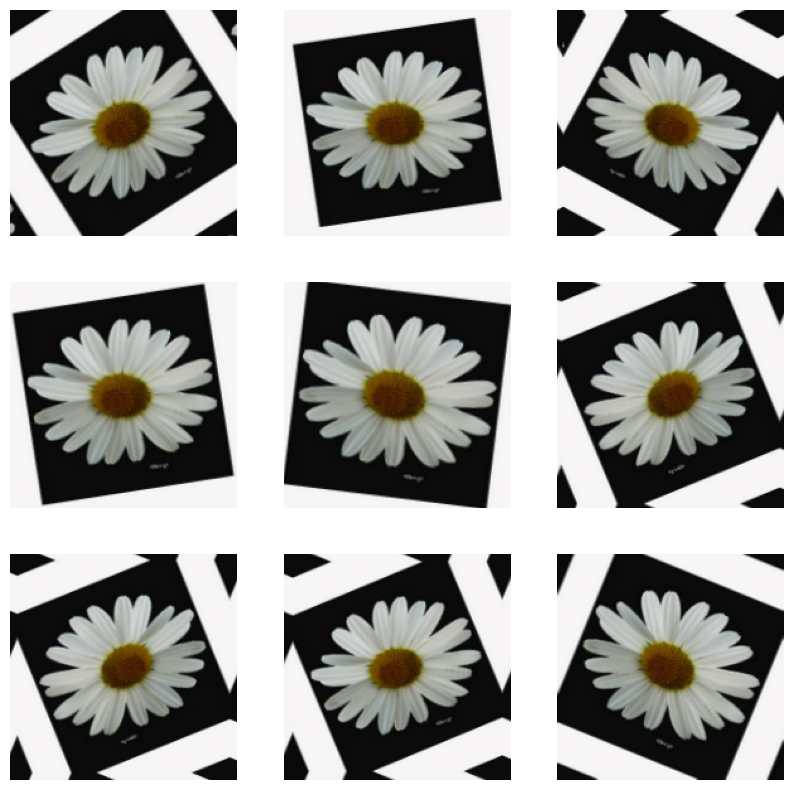

In [26]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Dropout
randomly dropping out neurons during training, dropout forces the network to learn more robust features and prevents it from relying too much on any single feature.

In [27]:
from tensorflow.keras import regularizers


In [28]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
  layers.Dense(num_classes, kernel_regularizer=regularizers.l2(0.01))
])

## Compile and train the model

In [29]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

In [31]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)


In [32]:
epochs = 32
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping]
)

Epoch 1/32
99/99 [==============================] - 14s 128ms/step - loss: 1.2541 - accuracy: 0.6878 - val_loss: 0.8480 - val_accuracy: 0.7614
Epoch 2/32
99/99 [==============================] - 12s 125ms/step - loss: 0.7517 - accuracy: 0.7701 - val_loss: 0.7734 - val_accuracy: 0.7741
Epoch 3/32
99/99 [==============================] - 12s 123ms/step - loss: 0.7092 - accuracy: 0.7796 - val_loss: 0.7381 - val_accuracy: 0.7792
Epoch 4/32
99/99 [==============================] - 12s 125ms/step - loss: 0.6555 - accuracy: 0.7999 - val_loss: 0.7050 - val_accuracy: 0.8046
Epoch 5/32
99/99 [==============================] - 13s 128ms/step - loss: 0.6639 - accuracy: 0.7961 - val_loss: 0.6493 - val_accuracy: 0.7893
Epoch 6/32
99/99 [==============================] - 13s 129ms/step - loss: 0.5928 - accuracy: 0.8182 - val_loss: 0.6996 - val_accuracy: 0.7792
Epoch 7/32
99/99 [==============================] - 13s 126ms/step - loss: 0.5963 - accuracy: 0.8220 - val_loss: 0.6287 - val_accuracy: 0.8249

## Visualise the results
Results after applying augmentation and Dropouts


In [34]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


25/25 [==============================] - 1s 45ms/step


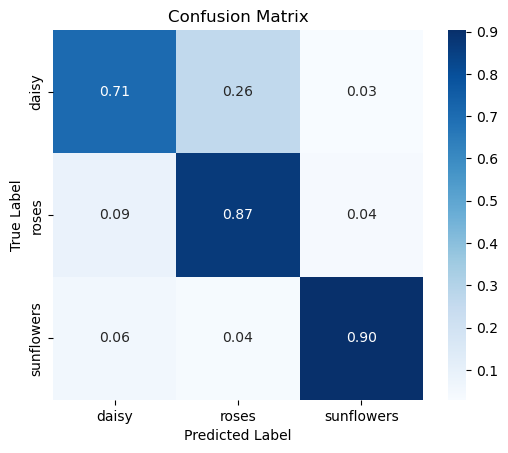

In [35]:

# Make predictions on the validation dataset
val_predictions = model.predict(val_ds)
val_predicted_labels = np.argmax(val_predictions, axis=1)
val_true_labels = []

for images, labels in val_ds:
    val_true_labels.extend(labels.numpy())

# Define class names
class_names = sorted([item.name for item in data_dir.glob('*') if item.is_dir()])

def show_confusion_matrix(true_labels, predicted_labels):
    """Compute confusion matrix and normalize."""
    confusion = confusion_matrix(true_labels, predicted_labels)
    confusion_normalized = confusion.astype("float") / confusion.sum(axis=1)[:, np.newaxis]
    axis_labels = class_names
    ax = sns.heatmap(
        confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
        cmap='Blues', annot=True, fmt='.2f', square=True)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Display the confusion matrix
show_confusion_matrix(val_true_labels, val_predicted_labels)


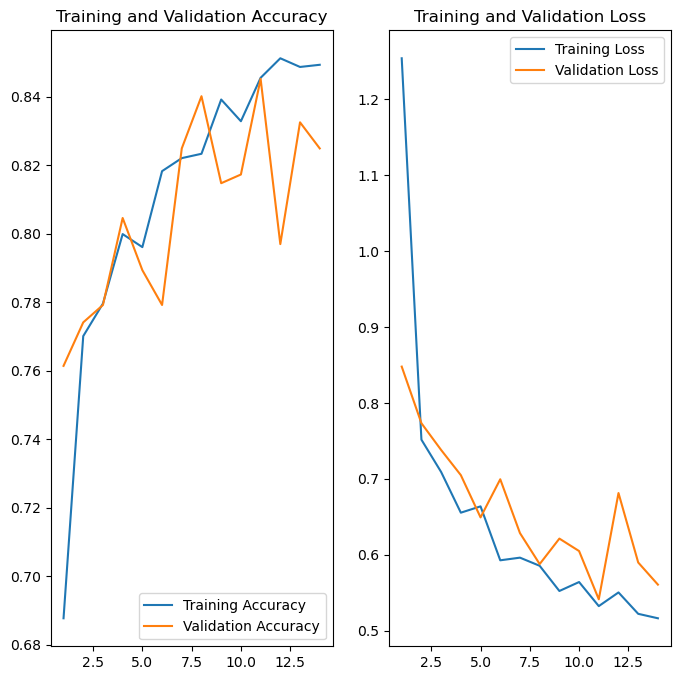

In [37]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, 15)

plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
Cell In[36], line 7
      4 loss = history.history['loss']
      5 val_loss = history.history['val_loss']
----> 7 epochs_range = range(epochs)
      9 plt.figure(figsize=(8, 8))
     10 plt.subplot(1, 2, 1)

TypeError: 'range' object is not callable## Testing

1/1 [==============================] - 0s 81ms/step


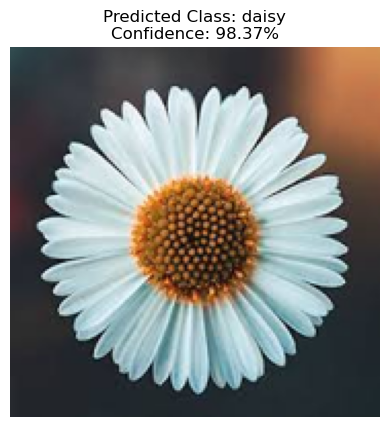

This image most likely belongs to daisy with a 98.37% confidence.


In [57]:
import pathlib
import PIL
from PIL import Image
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras


# Define the path to the flowers directory
data_dir = pathlib.Path('test')
modelpath = pathlib.Path ('models')

# Load the image
img_path = data_dir / 'daisy.jpeg'
img = Image.open(img_path)

path = modelpath / 'flower.h5'

# Preprocess the image
img_height, img_width = 180, 180  # Adjust the target size as needed
img = img.resize((img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

# Make predictions using the pre-trained model
model = keras.models.load_model(path)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Retrieve the predicted class label and confidence
class_names = ['daisy', 'rose', 'sunflower']
predicted_class = np.argmax(score)
predicted_class_name = class_names[predicted_class]
confidence = np.max(score) * 100

# Display the image
plt.imshow(img)
plt.axis('off')

if confidence >= 80:
    plt.title("Predicted Class: {}\nConfidence: {:.2f}%".format(predicted_class_name, confidence))
else:
    plt.title("Image Not Identified")

plt.show()

if confidence >= 80:
    print("This image most likely belongs to {} with a {:.2f}% confidence."
          .format(predicted_class_name, confidence))
else:
    print("The image was not identified with sufficient confidence.")


1/1 [==============================] - 0s 27ms/step


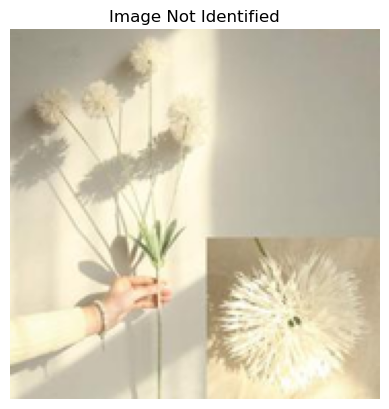

The image was not identified with sufficient confidence.


In [41]:
import pathlib
from PIL import Image
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Define the path to the flowers directory
data_dir = pathlib.Path('flowers')

# Load the image
img_path = data_dir / 'dandelion' / 'dannn.jpg'
img = Image.open(img_path)

# Preprocess the image
img_height, img_width = 180, 180  # Adjust the target size as needed
img = img.resize((img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

# Make predictions using the pre-trained model
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Retrieve the predicted class label and confidence
class_names = ['daisy', 'rose', 'sunflower']
predicted_class = np.argmax(score)
predicted_class_name = class_names[predicted_class]
confidence = np.max(score) * 100

# Display the image
plt.imshow(img)
plt.axis('off')

if confidence >= 70:
    plt.title("Predicted Class: {}\nConfidence: {:.2f}%".format(predicted_class_name, confidence))
else:
    plt.title("Image Not Identified")

plt.show()

if confidence >= 70:
    print("This image most likely belongs to {} with a {:.2f}% confidence."
          .format(predicted_class_name, confidence))
else:
    print("The image was not identified with sufficient confidence.")


In [41]:
from tensorflow.keras.models import load_model
import os

model.save(os.path.join('models','earlystop.h5'))
new_model = load_model(os.path.join('models','earlystop.h5'))

1/1 [==============================] - 0s 61ms/step


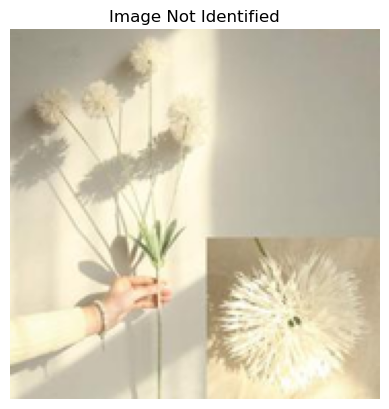

The image was not identified with sufficient confidence.


In [39]:
import pathlib
import PIL
from PIL import Image
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras


# Define the path to the flowers directory
data_dir = pathlib.Path('flowers')
modelpath = pathlib.Path ('models')

# Load the image
img_path = data_dir / 'dandelion' / 'dannn.jpg'
img = Image.open(img_path)

path = modelpath / 'earlystop.h5'

# Preprocess the image
img_height, img_width = 180, 180  # Adjust the target size as needed
img = img.resize((img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

# Make predictions using the pre-trained model
model = keras.models.load_model(path)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Retrieve the predicted class label and confidence
class_names = ['daisy', 'rose', 'sunflower']
predicted_class = np.argmax(score)
predicted_class_name = class_names[predicted_class]
confidence = np.max(score) * 100

# Display the image
plt.imshow(img)
plt.axis('off')

if confidence >= 85:
    plt.title("Predicted Class: {}\nConfidence: {:.2f}%".format(predicted_class_name, confidence))
else:
    plt.title("Image Not Identified")

plt.show()

if confidence >= 85:
    print("This image most likely belongs to {} with a {:.2f}% confidence."
          .format(predicted_class_name, confidence))
else:
    print("The image was not identified with sufficient confidence.")


In [2]:
import pathlib
from PIL import Image
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Define the path to the flowers directory
data_dir = pathlib.Path('flowers')

# Load the image
img_path = data_dir / 'sunflower' / '1.jpg'
img = Image.open(img_path)

# Preprocess the image
img_height, img_width = 180, 180  # Adjust the target size as needed
img = img.resize((img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

# Make predictions using the pre-trained model
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Retrieve the predicted class label and confidence
class_names = ['daisy', 'rose', 'sunflower']
predicted_class = np.argmax(score)
predicted_class_name = class_names[predicted_class]
confidence = np.max(score) * 100

# Display the image
plt.imshow(img)
plt.axis('off')
plt.title("Predicted Class: {}\nConfidence: {:.2f}%".format(predicted_class_name, confidence))
plt.show()

print("This image most likely belongs to {} with a {:.2f}% confidence."
      .format(predicted_class_name, confidence))


2023-05-15 23:18:42.275248: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-15 23:18:42.651511: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-15 23:18:43.211474: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-15 23:18:43.212284: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-15 23:18:44.955451: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

NameError: name 'model' is not defined

In [68]:
import pathlib
from PIL import Image
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


# Define the path to the flowers directory
data_dir = pathlib.Path('flowers')

# Load the image
img_path = data_dir / 'daisy'/'0.jpg'  

img = Image.open(img_path)

# Preprocess the image
img_height, img_width = 180, 180  # Adjust the target size as needed
img = img.resize((img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

# Make predictions using the pre-trained model
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Retrieve the predicted class label and confidence
class_names = ['daisy', 'rose', 'sunflower']  
predicted_class = np.argmax(score)
predicted_class_name = class_names[predicted_class]
confidence = np.max(score) * 100

print("This image most likely belongs to {} with a {:.2f}% confidence."
      .format(predicted_class_name, confidence))


1/1 [==============================] - 0s 24ms/step
This image most likely belongs to daisy with a 99.97% confidence.


In [40]:
# # import cv2
# # sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-sunflower.jpg"
# # sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

# import pathlib

# data_dir = pathlib.Path('flowers')
# print(data_dir)
# roses = (list(data_dir.glob('rose/*')))
# PIL.Image.open(str(roses[5]))

# img = tf.keras.utils.load_img(
#     sunflower_path, target_size=(img_height, img_width)
# )

# img_array = tf.keras.utils.img_to_array(img)
# img_array = tf.expand_dims(img_array, 0) # Create a batch

# predictions = model.predict(img_array)
# score = tf.nn.softmax(predictions[0])

# print(
#     "This image most likely belongs to {} with a {:.2f} percent confidence."
#     .format(class_names[np.argmax(score)], 100 * np.max(score))
# )

1/1 [==============================] - 0s 25ms/step
This image most likely belongs to sunflowers with a 94.87 percent confidence.


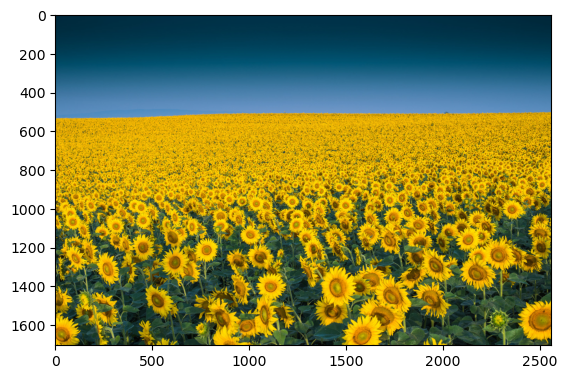

1/1 [==============================] - 0s 22ms/step
This image most likely belongs to roses with a 81.02 percent confidence.


In [45]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
img_height = 180
img_width = 180


img = cv2.imread("SN1.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

img = cv2.resize(img, (img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
     "This image most likely belongs to {} with a {:.2f} percent confidence."
     .format(class_names[np.argmax(score)], 100 * np.max(score)))


In [43]:
from tensorflow.keras.models import load_model
import os

model.save(os.path.join('models','classiproject.h5'))
new_model = load_model(os.path.join('models','classiproject.h5'))

In [ ]:
import tensorflow as tf
import cv2

# Load the saved model
model = tf.keras.models.load_model('Documents/mini/flower_classification/models/flower.h5')

# Define the input data
img_path = input("Enter the path of the image: ")
img = cv2.imread(img_path)

# Make a prediction using the loaded model
img = cv2.resize(img, (224, 224))  # resize the image to match the input size of the model
img = img / 255.0  # normalize the pixel values
img = tf.expand_dims(img, axis=0)  # add a batch dimension
prediction = model.predict(img)

# Get the predicted class and display the result
class_names = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
predicted_class_index = tf.argmax(prediction[0], axis=-1).numpy()
predicted_class_name = class_names[predicted_class_index]
confidence = prediction[0][predicted_class_index]
print(f"The model predicts that this image is a {predicted_class_name} with {confidence:.2%} confidence.")


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

1/1 [==============================] - 0s 60ms/step


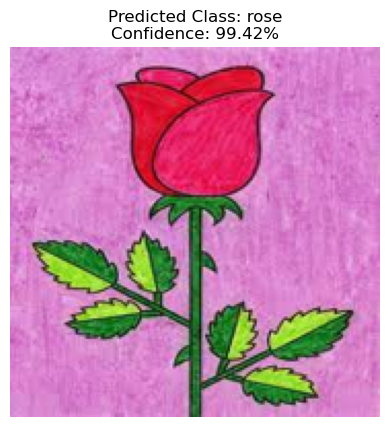

This image most likely belongs to rose with a 99.42% confidence.


In [42]:
import pathlib
import PIL
from PIL import Image
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras


# Define the path to the flowers directory
data_dir = pathlib.Path('flowers')
modelpath = pathlib.Path ('models')

# Load the image
img_path = data_dir / 'rose' / 'download.jpeg'
img = Image.open(img_path)

path = modelpath / 'earlystop.h5'

# Preprocess the image
img_height, img_width = 180, 180  # Adjust the target size as needed
img = img.resize((img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

# Make predictions using the pre-trained model
model = keras.models.load_model(path)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Retrieve the predicted class label and confidence
class_names = ['daisy', 'rose', 'sunflower']
predicted_class = np.argmax(score)
predicted_class_name = class_names[predicted_class]
confidence = np.max(score) * 100

# Display the image
plt.imshow(img)
plt.axis('off')

if confidence >= 85:
    plt.title("Predicted Class: {}\nConfidence: {:.2f}%".format(predicted_class_name, confidence))
else:
    plt.title("Image Not Identified")

plt.show()

if confidence >= 85:
    print("This image most likely belongs to {} with a {:.2f}% confidence."
          .format(predicted_class_name, confidence))
else:
    print("The image was not identified with sufficient confidence.")


In [ ]:
predictions = model.predict(input_data)


In [1]:
model.save("FlowerModel.h5")

NameError: name 'model' is not defined